# Full model for MacNeil *et al.* 2019 *Global status and conservation potential of reef sharks*

In [1]:
# Import packages
%matplotlib inline

import datetime
from itertools import product
import logging
import pickle
import pymc3 as pm
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from theano import tensor as tt
from theano import shared
from collections import Counter
import cmocean as co
import datetime as dt

In [2]:
# Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
# Set new plotting defaults
pct_formatter = StrMethodFormatter('{x:.1%}')

sns.set()
blue, green, *_ = sns.color_palette()

plt.rc('figure', figsize=(8, 6))

LABELSIZE = 15
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

# Data

### Import FinPrint data

In [4]:
fpdata = pd.read_csv('FinPrint_Set_Data.csv')
fpdata.columns.values

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (23,26,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [5]:
fpdata.Shark_Protection_Status[fpdata.Shark_Protection_Status.isnull()].unique()

array([nan], dtype=object)

In [6]:
fpdata.site_type.unique()

array(['I', 'B', 'A', 'V', 'C', 'O'], dtype=object)

In [7]:
fpdata.shape

(171810, 87)

In [8]:
fpdata.Shark_fishing_restrictions.unique()

array(['Species; Gear; Entrants; Temporal', 'Area; Gear; Species',
       'Species; Bag; Entrants; Gear; Area', 'Area', 'Area; Entrants',
       'Gear', nan, 'Area; Bag; Entrants', 'Gear; Bag; Area', 'Bag; Area',
       'Entrants; Temporal; Gear; Species', 'Entrants; Area',
       'Temporal; Entrants; Species', 'Gear; Species',
       'Area; Entrants; Species', 'Entrants',
       'Temporal; Size; Bag; Entrants; Species', 'Species',
       'Size; Bag; Entrants; Species', 'Species; Gear', 'Species; Bag',
       'Gear; Bag; Species', 'Gear; Species; Bag',
       'Size; Bag; Entrants; Species; Gear', 'Size', 'Entrants; Gear'],
      dtype=object)

In [9]:
# Import location-scale data
ldata = pd.read_excel('Location_Covariates.xlsx')
ldata.columns.values

array(['FP_location_id', 'FP_location_name', 'FP_location_code', 'EPI',
       'Ehealth', 'EcoVitality', 'EPI_location_name', 'TradeHub',
       'GINI_location_name', 'GINI_year', 'GINI', 'HDI_location_name',
       'HDI_year', 'HDI', 'WGI_location_name',
       'Voice_Accountability_year', 'Voice_Accountability',
       'Government_Effectiveness_year', 'Government_Effectiveness',
       'Regulatory_Quality_year', 'Regulatory_Quality',
       'Rule_of_Law_year', 'Rule_of_Law', 'Control_Corruption_year',
       'Control_Corruption', 'GDP_location_name', 'GDP_year',
       'GDP_per_capita_USD', 'Population_location_name',
       'Population_year', 'Population', 'SAUP_EEZ_name', 'Catch_year',
       'Total_catch_tonnes', 'Total_catch_reported_only',
       'Total_catch_value', 'Reef_catch_tonnes', 'Reef_catch_value',
       'Tuna_catch_tonnes', 'Tuna_catch_value', 'Reefshark_catch_tonnes',
       'Reefshark_catch_value', 'Shark_catch_tonnes', 'Shark_catch_value',
       'Bechedemer_catch_

In [10]:
critter = 'sharks'

In [11]:
fpdata['functional_group'].unique()

array(['apex', 'benthic_rover', 'guitar', 'pelagic', 'reef_meso',
       'large_ray', 'small_ray', 'coastal_rover', 'nocturnal_invader'],
      dtype=object)

In [12]:
# Grab only sharks
poo = fpdata[fpdata['functional_group'].isin(['reef_meso','apex','coastal_rover','benthic_rover', 'nocturnal_invader'])]

In [13]:
poo.functional_group.unique()

array(['apex', 'benthic_rover', 'reef_meso', 'coastal_rover',
       'nocturnal_invader'], dtype=object)

In [14]:
# Sum maxn's given set id's
tmp = poo.groupby(['set_id'], as_index=False)['maxn'].sum()
tmp.columns = ['set_id','MaxN_shark']

In [15]:
tmp.columns.values

array(['set_id', 'MaxN_shark'], dtype=object)

In [16]:
xdata = fpdata.merge(tmp, on=['set_id']).drop_duplicates(subset=['set_id'])

In [17]:
tmp.loc[tmp.set_id==2635].MaxN_shark

2075    9
Name: MaxN_shark, dtype: int64

In [18]:
np.shape(xdata)

(19090, 88)

In [19]:
# Break out Australia IOT and Dutch Antilles Leeward

xdata.location_name[xdata.site_name=='Ashmore'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Houtman Abrolhos'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Cocos-Keeling'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Christmas Island'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Pedro Bank'] = 'Jamaica PB'
xdata.location_name[xdata.site_name=='Cayo Serranilla'] = 'Columbia SF'
xdata.location_name[xdata.site_name=='Old Providence Island'] = 'Columbia SF'


xdata.location_name[xdata.site_name=='Aruba'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Bonaire'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Curacao'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Saba'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='Saba Bank'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Eustatius'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Maarten'] = 'Dutch Antilles Windward'


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [20]:
xdata.location_name.unique()

array(['USA-Western Atlantic', 'Bahamas', 'Australia-Pacific',
       'Australia IOT', 'Maldives', 'Malaysia', 'Solomon Islands',
       'Indonesia', 'Palau', 'American Samoa', 'New Caledonia', 'Belize',
       'Jamaica', 'Trinidad and Tobago', 'Vanuatu', 'British West Indies',
       'Fiji', 'Colombia', 'Australia-Indian Ocean', 'South Africa',
       'Mozambique', 'Niue', 'Japan', 'Seychelles', 'Taiwan', 'Kiribati',
       'Qatar', 'Federated States of Micronesia', 'Vietnam',
       'Philippines', 'French Polynesia', 'Samoa', 'Turks and Caicos',
       'Antigua and Barbuda', 'Barbados', 'Brazil', 'Columbia SF',
       'Jamaica PB', 'Mayotte', 'USA-Pacific', 'Sri Lanka', 'Tanzania',
       'Papua New Guinea', 'Tonga', 'New Zealand', 'India', 'Kenya',
       'Dutch Antilles Windward', 'Madagascar', 'Saudi Arabia', 'Guam',
       'Cook Islands', 'Dominican Republic', 'French West Indies',
       'Dutch Antilles Leeward', 'Cuba', 'Bermuda', 'Puerto Rico'],
      dtype=object)

In [21]:
np.shape(xdata)

(19090, 88)

In [22]:
# Cut rows with no visibility values
xdata = xdata[np.isfinite(xdata['visibility'])]
# Cut rows with no hard coral values
xdata = xdata[np.isfinite(xdata['hard_coral'])]
# Cut rows with no rugosity values
xdata = xdata[np.isfinite(xdata['substrate_relief_mean'])]

In [23]:
np.shape(xdata)

(15176, 88)

In [24]:
xdata.columns.values

array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [25]:
len(xdata.reef_id.unique())

371

## Models

In [26]:
#Responses
MaxN = xdata.MaxN_shark.values
OCC = (MaxN>0)*1

In [27]:
sum(OCC),sum(OCC)/len(MaxN),len(OCC)

(5730, 0.3775698471270427, 15176)

Code up iterator for analysis

In [28]:
# Hierarchical levels
Reef,Ir = indexall(np.array(xdata.reef_id.values))
nreefs = len(Reef)

Site,Is = subindexall(xdata.site_name.values,xdata.reef_id.values)
nsites = len(Site)

LocationR,Ilr = subindexall(xdata.location_name.values,xdata.reef_id.values)

LocationS,Ils = indexall(xdata.location_name.values)

Location,Il = subindexall(xdata.location_name.values,xdata.site_name.values)
nlocs = len(Location)

Region,Ig = subindexall(xdata.region_name.values,xdata.location_name.values)
nreg = len(Region)

Lox,Ilx = indexall(xdata.site_name.values)

In [29]:
# Lat/lon - national
Lat = np.array([np.mean(xdata.set_latitude.values[xdata.location_name.values==L]) for L in Location])
Lon = np.array([np.mean(xdata.set_longitude.values[xdata.location_name.values==L]) for L in Location])

In [30]:
# Location key
lkey = np.array([list(ldata.FP_location_name.values).index(l) for l in Location])
# Site key
skey = np.array([list(xdata.site_name.values).index(s) for s in Site])
# Reef key
rkey = np.array([list(xdata.reef_id.values).index(r) for r in Reef])

In [31]:
# Check uniqueness
len(xdata.reef_id.unique())/len(xdata.reef_id.values[rkey])

1.0

In [32]:
#"""
# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

In [33]:
## Location-level covariates

# Human development index
HDI = ldata.HDI.values[lkey]

# Voice and accountability
VOICE = ldata.Voice_Accountability.values[lkey]

# Population size
POP = stdize(np.log(ldata.Population.values[lkey]))

# Total catch
CATCH = stdize(np.log(ldata.Reef_catch_tonnes.values[lkey]))

# Shark catch
SCAT = stdize(np.log(ldata.Shark_catch_tonnes.values[lkey]+1))

# Beche de Mer
BDM = stdize(np.log(ldata.Bechedemer_catch_tonnes.values[lkey]+1))

# Tax haven
TAX = ldata.tax_haven.values[lkey]

# Shark sanctuary
SSA = ldata.Shark_Sanctuary.values[lkey]

In [34]:
# Site type
STY,Isty = indexall(xdata.site_type.values[skey])
nshabs = len(STY)

#### Reef-level covariates

In [35]:
# Temporary replacement of unknown protection status
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace(np.nan, 'Unknown', regex=True)

In [36]:
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace('Unknown', 'Closed',regex=True)

In [37]:
# Reef habitat type
RTY,Irty = indexall(xdata.reef_type.values[rkey])
nrty = len(RTY)

# Shark protection status
PRO = ['Open', 'Restricted', 'Closed']
Ipro = np.array([PRO.index(x) for x in xdata.Shark_Protection_Status.values[rkey]])
npro = len(PRO)

# Flags for mutual exclusions
CLO = (Ipro==PRO.index('Closed'))*1
noCLO = 1-(Ipro==PRO.index('Closed'))*1
RES = ((Ipro==PRO.index('Restricted'))*(1-(Ipro==PRO.index('Closed'))*1))*1

# MPA size - standardize only places that have area
MPS = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPS!=-999
#MPS[tmp] = stdize(np.log(MPS[tmp]+1))
MPS[tmp] = np.log(MPS[tmp]+1)/max(np.log(MPS[tmp]+1))
MPS[MPS==-999] = 0

# MPA age - standardize only places that have year
MPG = (xdata.mpa_year_founded.fillna(-999+2015).values[rkey]-2015)*-1
tmp = MPG!=999
#MPG[tmp] = stdize(MPG[tmp])
MPG[tmp] = MPG[tmp]/max(MPG[tmp])
MPG[MPG==999] = 0

# High compliance
HIG = (xdata.mpa_compliance.values[rkey]=='high')*1*CLO

# Remote
REM = (xdata.Remote.values[rkey]=='Yes')*1

# Gravity NP
GRAV = stdize(np.log(xdata.Grav_NP.values[rkey]+1))

# Gravity NC
GRAV_NC = stdize(np.log(xdata.Grav_NC.values[rkey]+1))

# Shark gear
xdata.Sharkgear = xdata.Shark_gears.fillna('None')
# Gillnet
GNET = np.array([('Gillnet' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Drumline
DRUM = np.array([('Drumline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Hook and line
HLIN = np.array([('Hook & Line' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Longline
LLIN = np.array([('Longline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Spear
SPE = np.array([('Spear' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Trawl
TRA = np.array([('Trawl' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Blast
BLA = np.array([('Blast' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Gillnets or longlines
GILL = ((GNET+LLIN)>0)*1

# Bag
BAG = np.array([('Bag' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Temporal
TEM = np.array([('Temporal' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Species
SPP = np.array([('Species' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]


# Local population growth
xdata['proportional_difference'] = xdata['population_proporationaldifference_2010.15'].fillna(0)
POPG = stdize(xdata.proportional_difference.values[rkey])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [38]:
# Depth
DEPTH = stdize(xdata.depth.values)

# Bait
tmp = xdata.bait_family.values
tmp[tmp=='Palinuridae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Lutjanidae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Carangidae'] = 'Other'
tmp[tmp=='Belonidae'] = 'Other'
tmp[tmp=='Coryphaenidae'] = 'Other'
tmp[tmp=='Scomberesocidae'] = 'Other'
tmp[tmp=='Osmeridae'] = 'Other'

BAIT,Ib = indexall(tmp)
nbait = len(BAIT)

# Visibility
VIS = stdize(xdata.visibility.values)

# Productivity
tmp = np.median(xdata.set_productivity_2017ave.values[xdata.set_productivity_2017ave.values>0])
xdata.set_productivity_2017ave = xdata.set_productivity_2017ave.fillna(tmp)
PROD = stdize(xdata.set_productivity_2017ave.values-np.mean(xdata.set_productivity_2017ave.values))

# Hard coral
HC = stdize(xdata.hard_coral.values)

# Rugosity
RUG = stdize(xdata.substrate_relief_mean.values)

# Algae
tmp = xdata.macroalgae.fillna(0)
ALG = stdize(tmp.values)

# Noon distance in fractional hours
DAY = np.abs(stdize(np.array([(dt.datetime.strptime(x,'%H:%M:%S')-dt.datetime.strptime('12:00:00','%H:%M:%S')).total_seconds()/60**2 for x in xdata.drop_time.values])))


# Number of observations
nobs = len(ALG)

Proportion of zeros

In [39]:
sum(OCC)/len(OCC)

0.3775698471270427

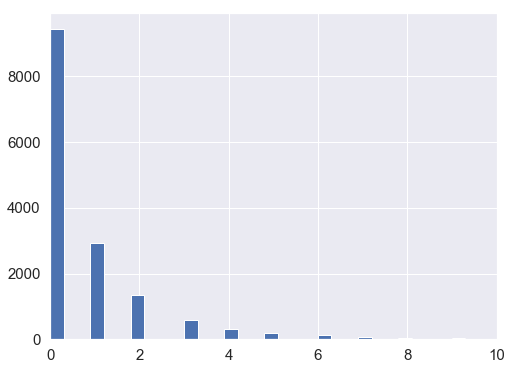

In [40]:
plt.hist(MaxN,bins=100)
plt.xlim(0,10);

In [41]:
nlocs

58

### Bayes model

In [42]:
Model = pm.Model()

with Model:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, 3)
    σ0_υ = pm.Uniform('σ0_υ',0 , 3)
    υ0 = pm.Normal('Regional_rate', π0, σ0_υ, shape=nreg)

    # National count model
    η2 = pm.Normal('Sanctuary', 0, 3)
    
    η = υ0[Ig]+η2*SSA
    σ0_η = pm.Exponential('σ0_η', 1)
    η0 = pm.Normal('η0', η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, 3, shape=nrty-1)
    κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)
    
    #κ2 = pm.Normal('Restricted', 0, 3)
    κ3 = pm.Normal('Closed', 0, 3)
    κ3a = pm.Normal('MPA_size', 0, 3)
    κ3b = pm.Normal('High_compliance', 0, 3)
    
    κ4 = pm.Normal('Gillnet_longline', 0, 3)
    κ5 = pm.Normal('Drumline', 0, 3)
    κ6 = pm.Normal('HookLine', 0, 3)
    
    κ7 = pm.Normal('Bag', 0, 3)
    κ7b = pm.Normal('Temporal', 0, 3)
    κ7c = pm.Normal('Species', 0, 3)
    
    κ8 = pm.Normal('Remote', 0, 3)
    κ9 = pm.Normal('Gravity_NP', 0, 3)
    κ10 = pm.Normal('Gravity_NC', 0, 3)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC
    
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = pm.Normal('Depth', 0, 3)
    
    ρ4 = pm.Normal('Visibililty', 0, 3)
    ρ5 = pm.Normal('Hard_coral', 0, 3)
    ρ6 = pm.Normal('Rugosity', 0, 3)
    ρ7 = pm.Normal('TimeODay', 0, 3)
    ρ8_ = pm.Normal('Bait_type', 0, 3, shape=nbait-1)
    ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]
    μ = tt.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = pm.Normal('Global_zeros', 0, 2)
    σ0_υ_z = pm.Exponential('σ0_υ_z', 1)
    υ0_z = pm.Normal('Regional_zeros', π0_z, σ0_υ_z, shape=nreg)
    σ0_η_z = pm.Exponential('σ0_η_z', 1)

    # National zeros model
    η1_z = pm.Normal('HDI', 0, 3)
    #η1b_z = pm.Normal('HDI2', 0, 3)
    η2_z = pm.Normal('VOICE', 0, 3)
    η3_z = pm.Normal('POP', 0, 3)
    η_z = υ0_z[Ig]+η1_z*HDI+η2_z*VOICE+η3_z*POP
    η0_z = pm.Normal('η0_z', η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = pm.invlogit(η0_z[Ils])

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)

In [43]:
# Sampling
with Model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, η0_z, POP, VOICE, HDI, σ0_η_z, Regional_zeros, σ0_υ_z, Global_zeros, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Gravity_NC, Gravity_NP, Remote, Species, Temporal, Bag, HookLine, Drumline, Gillnet_longline, High_compliance, MPA_size, Closed, Reef_type, η0, σ0_η, Sanctuary, Regional_rate, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [33:24<00:00,  4.31draws/s] 
There were 446 divergences after tuning. Increase `target_accept` or reparameterize.
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
There were 566 divergences after tuning. Increase `target_accept` or reparameterize.
There were 730 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [44]:
pm.waic(trace, Model)

/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=27962.52861372344, WAIC_se=272.34242902680364, p_WAIC=336.3945314019212, var_warn=1)

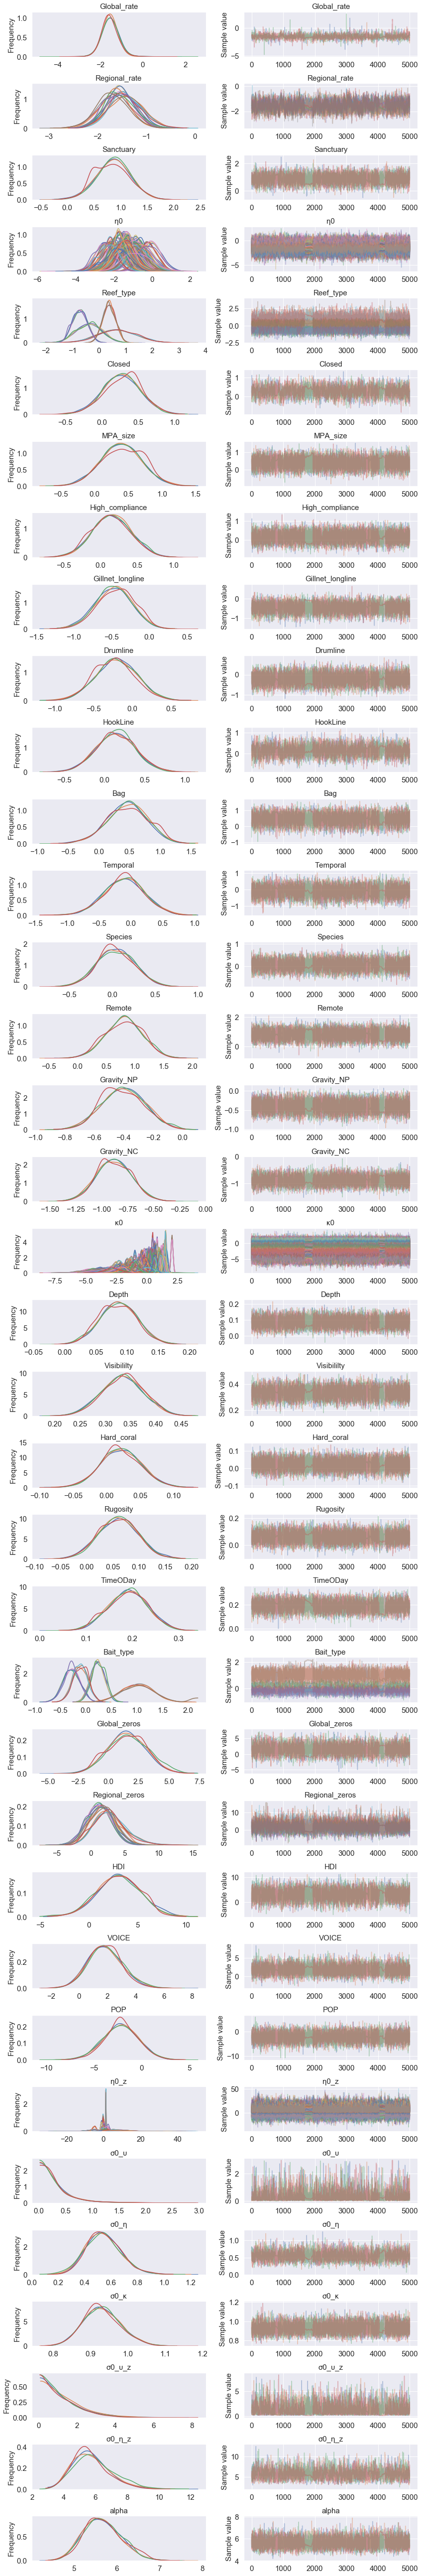

In [45]:
pm.traceplot(trace)
plt.savefig('Figure_S3_'+critter+'.jpg',dpi=300);

In [46]:
varset = ['Global_rate',
 'σ0_υ_interval__',
 'Regional_rate',
 'Sanctuary',
 'σ0_η_log__',
 'Reef_type',
 'Closed',
 'MPA_size',
 'High_compliance',
 'Gillnet_longline',
 'Drumline',
 'HookLine',
 'Bag',
 'Temporal',
 'Species',
 'Remote',
 'Gravity_NP',
 'Gravity_NC',
 'σ0_κ_interval__',
 'Depth',
 'Visibililty',
 'Hard_coral',
 'Rugosity',
          'TimeODay',
 'Bait_type',
 'Global_zeros',
 'σ0_υ_z_log__',
 'Regional_zeros',
 'σ0_η_z_log__',
 'HDI',
 'VOICE',
 'POP',
 'alpha_log__',
 'σ0_υ',
 'σ0_η',
 'σ0_κ',
 'σ0_υ_z',
 'σ0_η_z',
 'alpha']

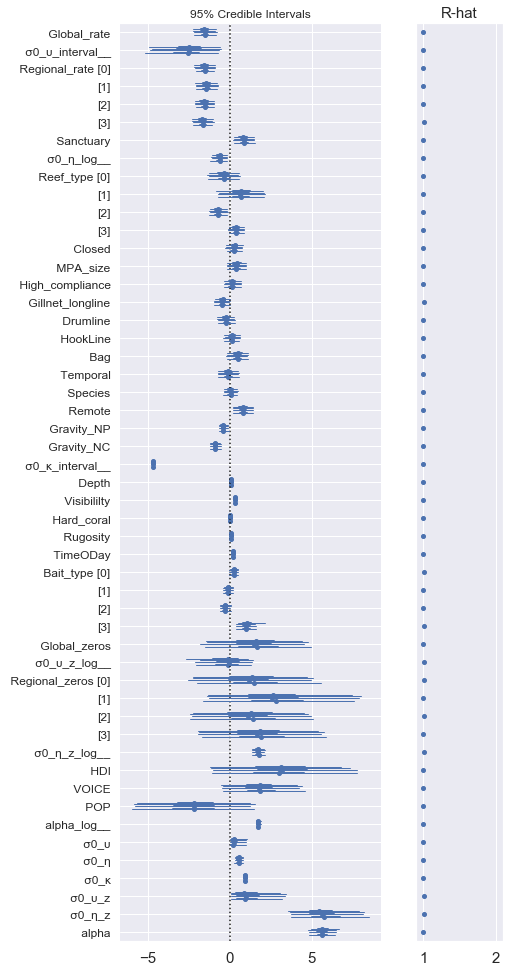

In [47]:
plt.figure(figsize=(8, 15))
pm.forestplot(trace,varnames=varset)
plt.savefig('Figure_S2_'+critter+'.jpg',dpi=300);

In [48]:
results = pm.backends.tracetab.trace_to_dataframe(trace)

In [49]:
# Edit column names
colnames = np.array(list(results.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])] = np.array(['κ0_'+str(r) for r in Reef])
colnames[np.array([list(colnames).index(x) for x in grep('η0_z',colnames)])] = np.array(['η0z_'+l for l in Location])
colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])] = np.array(['η0_'+l for l in Location])

#colnames[np.array([list(colnames).index(x) for x in grep('Site_type',colnames)])] = np.array(['Site_type_'+s for s in STY[1:]])

#colnames[np.array([list(colnames).index(x) for x in grep('Bait_type',colnames)])] = np.array(['Bait_type'+b for b in BAIT[1:]])

colnames[np.array([list(colnames).index(x) for x in grep('Reef_type',colnames)])] = np.array(['Reef_type_'+r for r in RTY[1:]])

colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate',colnames)])] = np.array(['Regional_rate_'+r for r in Region])

results.columns = list(colnames)

In [50]:
# Drop reef-specific columns
results = results.drop(list(colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])]),axis=1)
# Export posteriors
results.to_csv(critter+'_ZINB_results.csv')
# Export summary statistics 
results.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'}).to_csv(critter+'_ZINB_summary_stats.csv')

## Posterior predictive checks

In [51]:
ppc = pm.sample_ppc(trace, model=Model)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 20000/20000 [01:23<00:00, 238.40it/s]


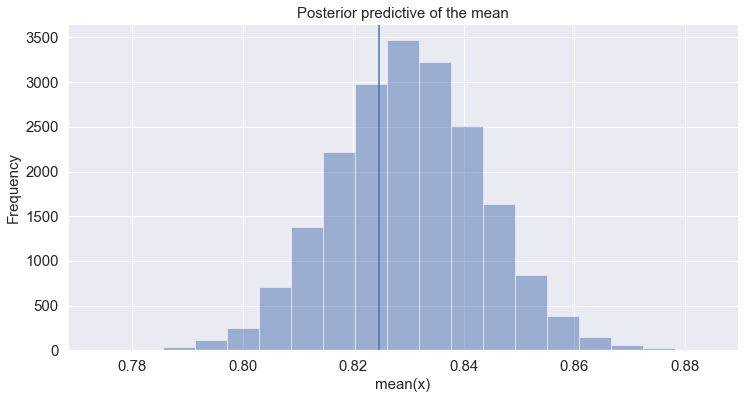

In [52]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['Yi']], bins=19, alpha=0.5)
ax.axvline(MaxN.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_Ex_'+critter+'.jpg',dpi=300);

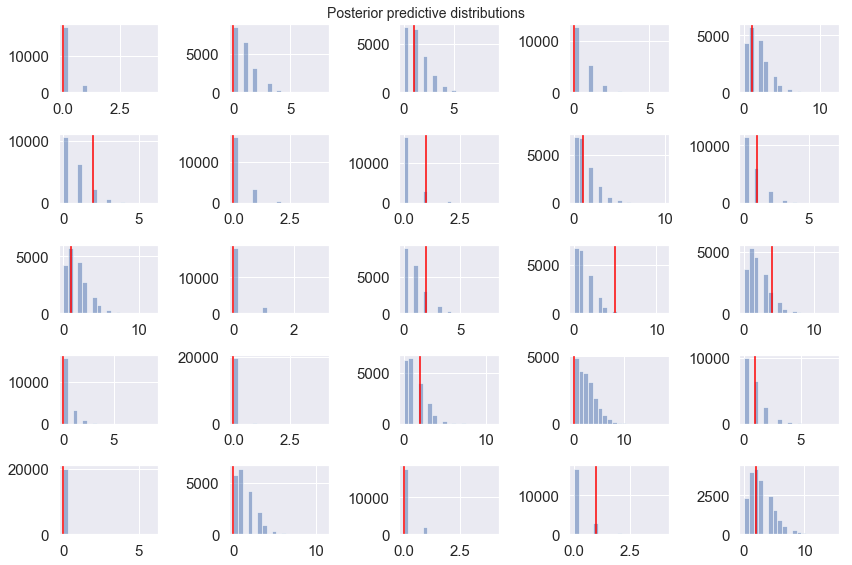

In [53]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(MaxN[indx[i]],c='red')

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_Ex'+critter+'.jpg',dpi=300);

In [54]:
tmp = []
for i in range(nobs):
    #if MaxN[i]>np.mean(PPC[i]):
    if MaxN[i]>np.quantile(PPC[i],.975):
        tmp += [list(xdata.iloc[i].values)]
    else:
        pass
deets = np.array(tmp)

In [55]:
# Outside prediction rate
len(deets)/len(MaxN)

0.010938323668950976

# Results plots

In [56]:
# Rename parameters
p_presence = invlogit(results[colnames[np.array([list(colnames).index(x) for x in grep('η0z',colnames)])]])
p_presence.columns = list(Location)
p_presence = p_presence[p_presence.median().sort_values().index.values]
Plocation = p_presence.columns.values

### P(counts)

In [57]:
# Add sample sizes (nreefs) per country
Plocationz = [c+" ("+str(list(np.array(LocationR)[Ilr]).count(c))+")" for c in Plocation]

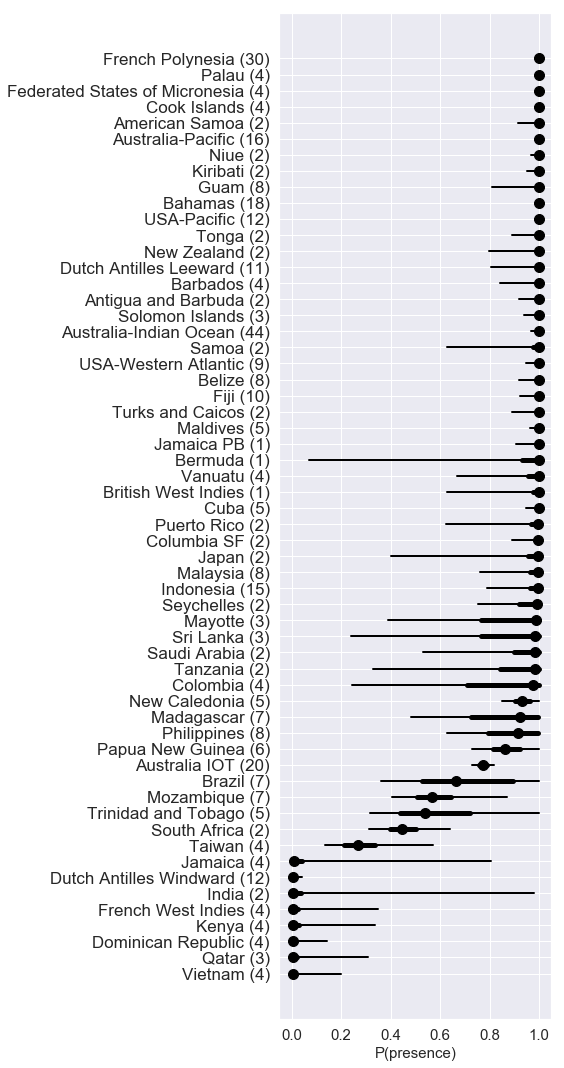

In [58]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111)
[gelplot(ax,p_presence[Plocation[i]],i,csize=20,lwd50=5,lwd95=2) for i in range(nlocs)]
ax.set_yticks(range(nlocs))
ax.set_yticklabels(Plocationz,fontsize=17)
ax.set_xlabel('P(presence)')
plt.tight_layout()
plt.savefig('ED_Figure_2.pdf');

### Ex(MaxN|pressence)

In [59]:
ex_abu = np.exp(results[colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])]])
ex_abu.columns = list(Location)
ex_abu = ex_abu[ex_abu.median().sort_values().index.values]
Elocation = ex_abu.columns.values

In [60]:
# Add sample sizes (nreefs) per country
Elocationz = [c+" ("+str(list(np.array(LocationR)[Ilr]).count(c))+")" for c in Elocation]

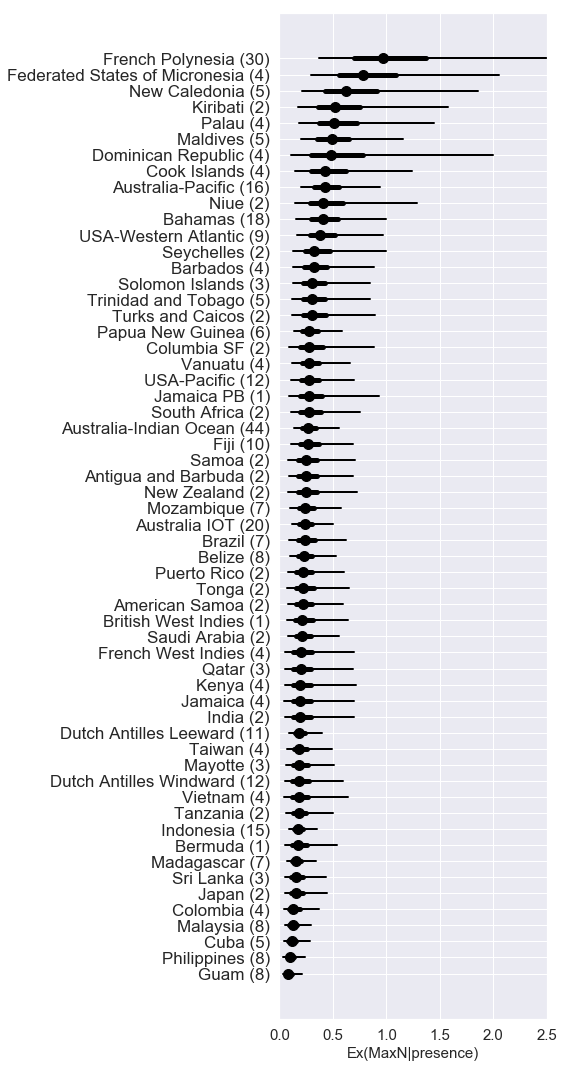

In [61]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111)
[gelplot(ax,ex_abu[Elocation[i]],i,csize=20,lwd50=5,lwd95=2) for i in range(nlocs)]
ax.set_yticks(range(nlocs))
ax.set_xlim(0,2.5)
ax.set_yticklabels(Elocationz,fontsize=17)
ax.set_xlabel('Ex(MaxN|presence)')
plt.tight_layout()
plt.savefig('ED_Figure_3.pdf');

In [62]:
np.exp(np.percentile(results['Regional_rate_Coral Triangle'].values, (50,25,97.5)))

array([0.18982439, 0.15325259, 0.34949504])

In [63]:
np.exp(np.percentile(results['Regional_rate_Western Atlantic'].values, (50,25,97.5)))

array([0.21681709, 0.17723144, 0.40826596])

In [64]:
np.exp(np.percentile(results['Regional_rate_Pacific'].values, (50,25,97.5)))

array([0.23917141, 0.19229368, 0.47550832])

In [65]:
np.exp(np.percentile(results['Regional_rate_Indian Ocean'].values, (50,25,97.5)))

array([0.21418909, 0.17429726, 0.38165078])